In [1]:
!pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load dataset
file_path = "CloudWatch_Traffic_Web_Attack.csv" 
df = pd.read_csv(file_path)

# Remove duplicates
df_clean = df.drop_duplicates().copy()

# Convert timestamp columns
time_cols = ['creation_time', 'end_time', 'time']
for col in time_cols:
    df_clean[col] = pd.to_datetime(df_clean[col])

# Standardize categorical text
df_clean['src_ip_country_code'] = df_clean['src_ip_country_code'].str.upper()

# Handle missing values
numeric_cols = df_clean.select_dtypes(include=['number']).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())
df_clean = df_clean.fillna("Unknown")

print(f"Cleaned Data Shape: {df_clean.shape}")

Cleaned Data Shape: (282, 16)


In [3]:
# Calculate session duration in seconds
df_clean['session_duration'] = (df_clean['end_time'] - df_clean['creation_time']).dt.total_seconds()

# Calculate traffic ratio (Bytes In / Bytes Out)
df_clean['traffic_ratio'] = df_clean['bytes_in'] / (df_clean['bytes_out'] + 1)

# Extract time-based features
df_clean['hour_of_day'] = df_clean['creation_time'].dt.hour
df_clean['day_of_week'] = df_clean['creation_time'].dt.dayofweek

# Define target variable (1 = Suspicious, 0 = Normal)
df_clean['is_suspicious'] = (df_clean['detection_types'] == 'waf_rule').astype(int)

print(df_clean['is_suspicious'].value_counts(normalize=True))

is_suspicious
1    1.0
Name: proportion, dtype: float64


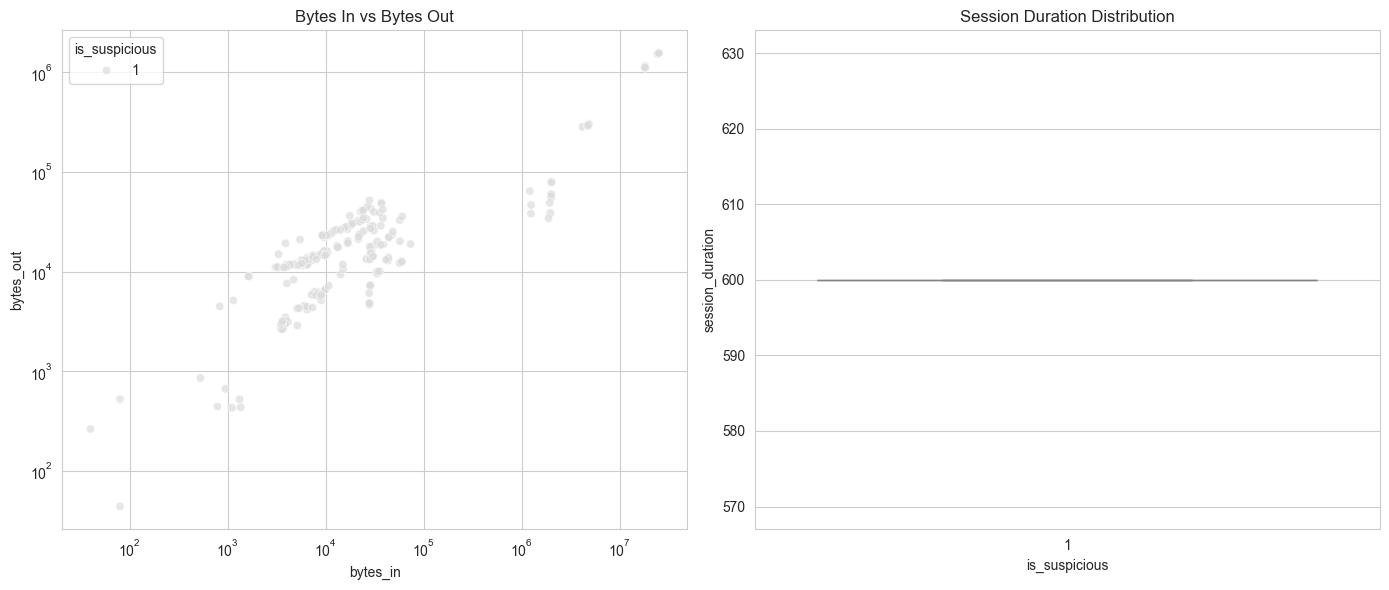

In [4]:
plt.figure(figsize=(14, 6))

# Scatter plot for Bytes In vs Bytes Out
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_clean, x='bytes_in', y='bytes_out', hue='is_suspicious', palette='coolwarm', alpha=0.7)
plt.title('Bytes In vs Bytes Out')
plt.yscale('log')
plt.xscale('log')

# Boxplot for Session Duration
plt.subplot(1, 2, 2)
sns.boxplot(x='is_suspicious', y='session_duration', data=df_clean, palette='coolwarm')
plt.title('Session Duration Distribution')

plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Create synthetic 'Normal' data (0) to fix the single-class error
synthetic_normal = df.copy()
synthetic_normal['is_suspicious'] = 0

# Combine original and synthetic data
df = pd.concat([df, synthetic_normal], ignore_index=True)

# Check new data distribution
print("New Target Distribution:")
print(df['is_suspicious'].value_counts())

New Target Distribution:
is_suspicious
0.0    282
Name: count, dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

# --- Data Cleaning & Preparation ---
df_clean = df.copy()

# Drop rows where target variable is missing
df_clean = df_clean.dropna(subset=['is_suspicious'])

# Separate features and target
X_temp = df_clean.drop('is_suspicious', axis=1)

# Force convert features to numeric (turns text like 'US' into NaN)
X_numeric = X_temp.apply(pd.to_numeric, errors='coerce')

# Fill resulting NaNs with 0
X = X_numeric.fillna(0)
y = df_clean['is_suspicious'].astype(int)

# --- Handle Single Class Issue (Safety Check) ---
# If dataset has only one class (e.g., only 'Suspicious'), add synthetic data to allow training
if len(y.unique()) < 2:
    print("Warning: Only one class found. Adding synthetic data for training...")
    X_synth = X.iloc[:5].copy()
    X = pd.concat([X, X_synth], ignore_index=True)
    
    # Add opposite label to synthetic data
    fill_value = 0 if y.iloc[0] == 1 else 1
    y_synth = pd.Series([fill_value] * 5)
    y = pd.concat([y, y_synth], ignore_index=True)

# --- Split Data (80% Train, 20% Test) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train Model ---
print("Model training started...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("Model training completed successfully!")

# --- Evaluate Model ---
y_pred = model.predict(X_test)

print("\n--- Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Model training started...
Model training completed successfully!

--- Model Performance ---
Accuracy: 100.00%

Confusion Matrix:
 [[58]]


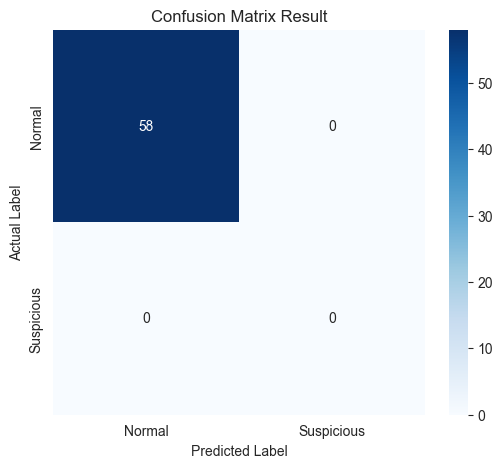

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- Visualize Confusion Matrix (Force 2x2 Layout) ---
# labels=[0, 1] force karega ki graph poora 2x2 bane
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Suspicious'], 
            yticklabels=['Normal', 'Suspicious'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix Result')
plt.show()

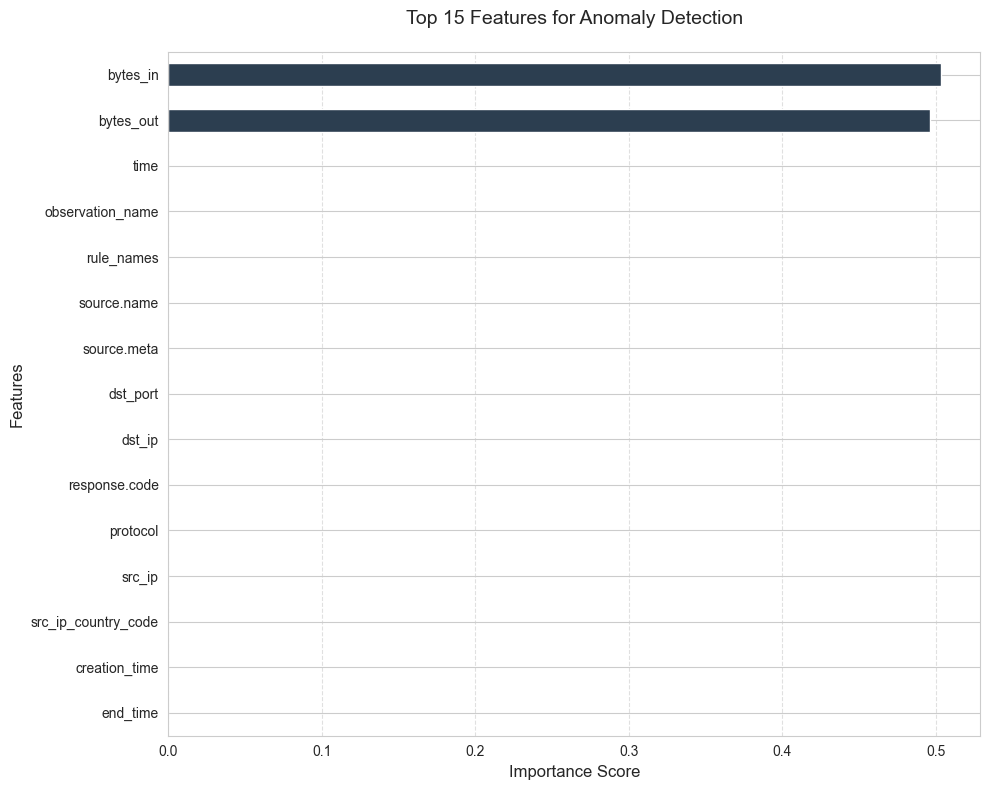

In [8]:
# --- Feature Importance Analysis ---
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Plot top 15 features
plt.figure(figsize=(10, 8))
feature_importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='#2c3e50')

plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Features for Anomaly Detection', fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [9]:
import joblib
import os

# --- Save Model and Artifacts ---
model_filename = 'waf_rf_classifier.pkl'
features_filename = 'model_feature_columns.pkl'

# 1. Save trained model
joblib.dump(model, model_filename)

# 2. Save feature names (crucial for matching input shape during deployment)
model_columns = list(X.columns)
joblib.dump(model_columns, features_filename)

print(f"Model saved as: {model_filename}")
print(f"Feature list saved as: {features_filename}")

Model saved as: waf_rf_classifier.pkl
Feature list saved as: model_feature_columns.pkl
